In [18]:
import numpy as np
import matplotlib.pyplot as plt


In [80]:
# Matrix pretty print
# Enhanced upon reference: https://stackoverflow.com/a/13214945
def fmt_matrix(matrix, header_row = False):
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = ''.join('| {{:{}}} '.format(x) for x in lens) + '|'
    sep_row = lambda c, sep = '|': sep.join([''] + [c*(l+2) for l in lens] + [''])
    table = [fmt.format(*row) for row in s]
    if (header_row):
        table.insert(1, sep_row('—'))
    return '\n'.join(table)

In [239]:
# Q1

class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, split_metadata=None, left=None, right=None, value=None):
        # Feature index for splitting
        self.feature = feature
        # Threshold value for splitting
        self.threshold = threshold
        # Split metadata for logging
        self.split_metadata = split_metadata
        # Left subtree
        self.left = left
        # Right subtree
        self.right = right
        # Leaf node value (class label)
        self.value = value
        # Node counter
        self.node_count = 1
        if left is not None: self.node_count += left.node_count
        if right is not None: self.node_count += right.node_count


    def __str__(self, indent=""):
        node_str = ""
        if self.value is not None:
            node_str += f"Leaf({self.value})\n"
        else:
            node_str += f"Dcsn(x_{self.feature} >= {self.threshold})\n"
            if self.left:
                node_str += f"{indent}├─ L: {self.left.__str__(indent + '│  ')}"
            if self.right:
                node_str += f"{indent}└─ R: {self.right.__str__(indent + '   ')}"
        return node_str

    def log_split_metadata(self):
        log_matrix = [["Feature", "Threshold", "Information Gain", "Split Information", "Gain Ratio"]]
        for (feature, threshold), info_gain, split_information in self.split_metadata:
            row = [feature, threshold, info_gain, split_information]
            if split_information == 0:
                row.append("NA")
            else:
                row.append(info_gain/split_information)
            log_matrix.append(row)
        return "Split candidates:\n" + fmt_matrix(log_matrix, True)

class DecisionTree:
    def __init__(self, force_node_creation=False):
        self.root = None
        self.force_node_creation = force_node_creation

    def entropy(self, labels):
        unique, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def get_information_gain_ratio_data(self, data, labels, split):

        total_entropy = self.entropy(labels)

        split_feature, split_thresh = split
        split_mask = data[:, split_feature] >= split_thresh
        left_labels = labels[split_mask]
        right_labels = labels[~split_mask]

        left_weight = len(left_labels) / len(labels)
        right_weight = len(right_labels) / len(labels)

        left_entropy = self.entropy(left_labels)
        right_entropy = self.entropy(right_labels)

        information_gain = total_entropy - (
            left_weight * left_entropy + right_weight * right_entropy
        )
        split_information = self.entropy(split_mask)

        return information_gain, split_information

    def find_split_candidates(self, data, labels):
        candidates = set()
        num_samples, num_features = data.shape

        for feature in range(num_features):
            sorted_indices = np.argsort(data[:, feature])
            sorted_data_values = data[:, feature][sorted_indices]
            sorted_labels = labels[sorted_indices]
            unique_data_values, unique_data_indices = np.unique(sorted_data_values, return_index=True)

            label_groups = np.split(sorted_labels, unique_data_indices[1:])
            prev_label_group = np.unique(label_groups[0])
            for dval, label_group in zip(unique_data_values[1:], label_groups[1:]):
                curr_label_group = np.unique(label_group)
                # Add the current data value as a candidate:
                # 1. If either prev or next group have multiple output labels,
                # 2. If both groups were pure, just check if they match
                if (len(prev_label_group) > 1) or (len(curr_label_group) > 1) or (prev_label_group[0] != curr_label_group[0]):
                    candidates.add((feature, dval))
                prev_label_group = curr_label_group

        return list(candidates)

    def find_best_split(self, data, labels, candidates):
        best_split = None
        split_metadata = []
        if (len(candidates) == 0): return best_split, split_metadata

        best_gain_ratio = 0
        for split in candidates:
            info_gain, split_info = self.get_information_gain_ratio_data(data, labels, split)
            split_metadata.append((split, info_gain, split_info))
            if split_info != 0 : # Ignore splits with split_information = 0
                gain_ratio = info_gain/split_info
                if (
                    best_gain_ratio < gain_ratio or
                     (self.force_node_creation and best_gain_ratio <= gain_ratio)
                ): # Ignore splits with gain_ratio = 0, unless forced
                    best_gain_ratio = gain_ratio
                    best_split = split
        return best_split, split_metadata

    def build_tree(self, data, labels):

        if len(data) == 0: # No data to split
            return DecisionTreeNode(value=1) # Default to class 1

        unique_labels, label_counts = np.unique(labels, return_counts=True)
        if len(unique_labels) == 1: # Pure node
            return DecisionTreeNode(value=unique_labels[0]) # Select the first "label"

        split_candidates = self.find_split_candidates(data, labels)
        best_split, split_metadata = self.find_best_split(data, labels, split_candidates)
        if best_split is None:
            if (label_counts[1] >= label_counts[0]): # In case of equal counts, prefer 1
                return DecisionTreeNode(value=unique_labels[1])
            else:
                return DecisionTreeNode(value=unique_labels[0])

        best_split_feature, best_split_thresh = best_split
        split_mask = data[:, best_split_feature] >= best_split_thresh
        left_data, left_labels = data[split_mask], labels[split_mask]
        right_data, right_labels = data[~split_mask], labels[~split_mask]

        left_subtree = self.build_tree(left_data, left_labels)
        right_subtree = self.build_tree(right_data, right_labels)

        return DecisionTreeNode(
            feature=best_split_feature,
            threshold=best_split_thresh,
            split_metadata=split_metadata,
            left=left_subtree,
            right=right_subtree,
        )

    def fit(self, data, labels):
        self.root = self.build_tree(data, labels)

    def predict(self, data):
        def predict_tree(node, sample):
            if node.value is not None:
                return node.value
            if sample[node.feature] >= node.threshold:
                return predict_tree(node.left, sample)
            else:
                return predict_tree(node.right, sample)

        predictions = [predict_tree(self.root, sample) for sample in data]
        return np.array(predictions)


def load_data(filename):
    data = []
    labels = []

    with open(filename, 'r') as file:
        for line in file:
            values = line.strip().split(' ')
            if (len(values) < 2): continue
            data.append(list(map(float, values[:-1])))
            labels.append(int(values[-1]))

    return np.array(data), np.array(labels)

def split_data(data, labels, train_split = 0.8):
    size = len(data)
    rng = np.random.default_rng()
    shuffle_order = np.arange(size)
    rng.shuffle(shuffle_order)
    split_index = int(size*train_split)
    return [
        (data[shuffle_order][:split_index], labels[shuffle_order][:split_index]),
        (data[shuffle_order][split_index:], labels[shuffle_order][split_index:])
    ]


In [240]:
# Reference: https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07

def plot_decision_tree_regions(X, y, trained_model, plot_boundary=True, plot_scatter=True, axs=None):
    # define bounds of the plot
    plot_margin = 0.25
    min1, max1 = X[:, 0].min()-plot_margin, X[:, 0].max()+plot_margin
    min2, max2 = X[:, 1].min()-plot_margin, X[:, 1].max()+plot_margin

    if axs is None:
        axs = plt.subplots(1, 1)[1]

    if plot_boundary:
        # define the x and y scale
        x1grid = np.arange(min1, max1, 0.01)
        x2grid = np.arange(min2, max2, 0.01)
        # create all of the lines and rows of the grid
        xx, yy = np.meshgrid(x1grid, x2grid)
        # flatten each grid to a vector
        r1, r2 = xx.flatten(), yy.flatten()
        r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
        # horizontal stack vectors to create x1,x2 input for the trained_model
        grid = np.hstack((r1,r2))
        # make predictions for the grid
        yhat = trained_model.predict(grid)
        # reshape the predictions back into a grid
        zz = yhat.reshape(xx.shape)
        # plot the grid of x, y and z values as a surface
        axs.contourf(xx, yy, zz, cmap='Paired')

    if plot_scatter:
        # create scatter plot for samples from each class
        for class_value in np.unique(y):
            # get row indexes for samples with this class
            row_ix = np.where(y == class_value)
            # create scatter of these samples
            axs.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    axs.axis('scaled')
    axs.set_xlim((min1,max1))
    axs.set_ylim((min2,max2))

def plot_decision_tree_regions_o(X, y, trained_model, plot_boundary=True, plot_scatter=True):
    # define bounds of the domain
    plot_margin = 0.25
    min1, max1 = X[:, 0].min()-plot_margin, X[:, 0].max()+plot_margin
    min2, max2 = X[:, 1].min()-plot_margin, X[:, 1].max()+plot_margin
    if plot_boundary:
        # define the x and y scale
        x1grid = np.arange(min1, max1, 0.01)
        x2grid = np.arange(min2, max2, 0.01)
        # create all of the lines and rows of the grid
        xx, yy = np.meshgrid(x1grid, x2grid)
        # flatten each grid to a vector
        r1, r2 = xx.flatten(), yy.flatten()
        r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
        # horizontal stack vectors to create x1,x2 input for the trained_model
        grid = np.hstack((r1,r2))
        # make predictions for the grid
        yhat = trained_model.predict(grid)
        # reshape the predictions back into a grid
        zz = yhat.reshape(xx.shape)
        # plot the grid of x, y and z values as a surface
        plt.contourf(xx, yy, zz, cmap='Paired')
    if plot_scatter:
        # create scatter plot for samples from each class
        for class_value in np.unique(y):
            # get row indexes for samples with this class
            row_ix = np.where(y == class_value)
            # create scatter of these samples
            plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    plt.axis('scaled')
    plt.xlim((min1,max1))
    plt.ylim((min2,max2))


<ipython-input-240-90416be0b1dd>:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


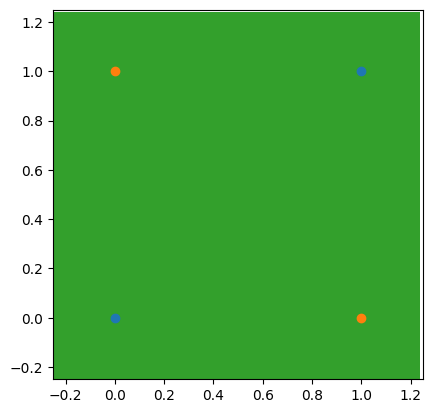

In [241]:
# Q2.2 - Case 1
data = np.array([
    [0., 0.],
    [0., 1.],
    [1., 0.],
    [1., 1.],
])
labels = np.array([0, 1, 1, 0])

tree = DecisionTree()
tree.fit(data, labels)
plot_decision_tree_regions(data, labels, tree)

<ipython-input-240-90416be0b1dd>:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


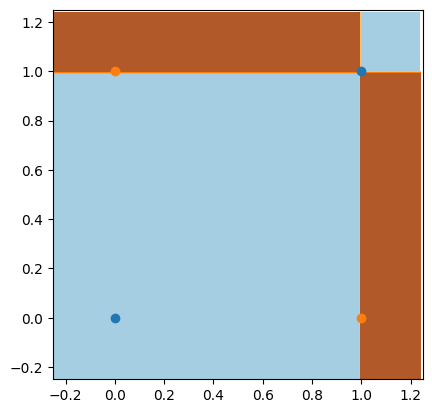

In [243]:
# Q2.2 - Case 2 - Forced node creation
tree = DecisionTree(force_node_creation=True)
tree.fit(data, labels)
plot_decision_tree_regions(data, labels, tree)

In [246]:
# Q2.3

data, labels = load_data('Druns.txt')
tree = DecisionTree()
tree.fit(data, labels)

print(tree.root.log_split_metadata())

Split candidates:
| Feature | Threshold | Information Gain    | Split Information  | Gain Ratio           |
|—————————|———————————|—————————————————————|————————————————————|——————————————————————|
| 1       | 8.0       | 0.18905266854301617 | 0.4394969869215134 | 0.4301569161309807   |
| 1       | -1.0      | 0.04417739186726133 | 0.4394969869215134 | 0.10051807676021828  |
| 0       | 0.1       | 0.04417739186726133 | 0.4394969869215134 | 0.10051807676021828  |
| 1       | 7.0       | 0.03827452220629246 | 0.6840384356390417 | 0.055953759631263526 |
| 1       | 0.0       | 0.03827452220629246 | 0.6840384356390417 | 0.055953759631263526 |
| 1       | 6.0       | 0.19958702318968735 | 0.8453509366224364 | 0.23609960614360798  |


In [203]:
# Q2.4

data, labels = load_data('D3leaves.txt')
tree = DecisionTree()
tree.fit(data, labels)

print(tree.root)

Dcsn(x_1 >= 2.0)
├─ L: Leaf(1)
└─ R: Dcsn(x_0 >= 10.0)
   ├─ L: Leaf(1)
   └─ R: Leaf(0)



In [204]:
# Q2.5 - D1
data, labels = load_data('D1.txt')
tree = DecisionTree()
tree.fit(data, labels)

print(tree.root)

Dcsn(x_1 >= 0.201829)
├─ L: Leaf(1)
└─ R: Leaf(0)



In [205]:
# Q2.5 - D2
data, labels = load_data('D2.txt')
tree = DecisionTree()
tree.fit(data, labels)

print(tree.root)

Dcsn(x_0 >= 0.533076)
├─ L: Dcsn(x_1 >= 0.228007)
│  ├─ L: Dcsn(x_1 >= 0.424906)
│  │  ├─ L: Leaf(1)
│  │  └─ R: Dcsn(x_0 >= 0.708127)
│  │     ├─ L: Leaf(1)
│  │     └─ R: Dcsn(x_1 >= 0.32625)
│  │        ├─ L: Dcsn(x_0 >= 0.595471)
│  │        │  ├─ L: Dcsn(x_0 >= 0.646007)
│  │        │  │  ├─ L: Leaf(1)
│  │        │  │  └─ R: Dcsn(x_1 >= 0.403494)
│  │        │  │     ├─ L: Leaf(1)
│  │        │  │     └─ R: Leaf(0)
│  │        │  └─ R: Leaf(0)
│  │        └─ R: Leaf(0)
│  └─ R: Dcsn(x_0 >= 0.887224)
│     ├─ L: Dcsn(x_1 >= 0.037708)
│     │  ├─ L: Dcsn(x_1 >= 0.082895)
│     │  │  ├─ L: Leaf(1)
│     │  │  └─ R: Dcsn(x_0 >= 0.960783)
│     │  │     ├─ L: Leaf(1)
│     │  │     └─ R: Leaf(0)
│     │  └─ R: Leaf(0)
│     └─ R: Dcsn(x_0 >= 0.850316)
│        ├─ L: Dcsn(x_1 >= 0.169053)
│        │  ├─ L: Leaf(1)
│        │  └─ R: Leaf(0)
│        └─ R: Leaf(0)
└─ R: Dcsn(x_1 >= 0.88635)
   ├─ L: Dcsn(x_0 >= 0.041245)
   │  ├─ L: Dcsn(x_0 >= 0.104043)
   │  │  ├─ L: Leaf(1)
   │  │  └

<ipython-input-199-90416be0b1dd>:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


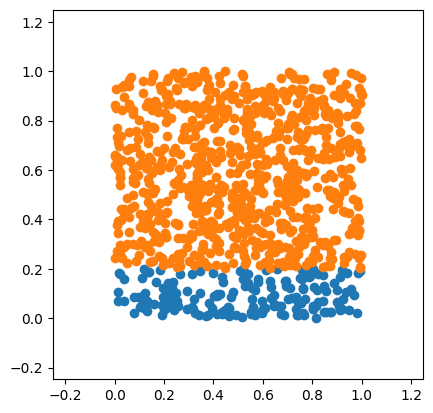

In [206]:
# Q2.6 - D1 scatter

data, labels = load_data('D1.txt')
tree = DecisionTree()
tree.fit(data, labels)

plot_decision_tree_regions(data, labels, tree, plot_boundary=False)

<ipython-input-199-90416be0b1dd>:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


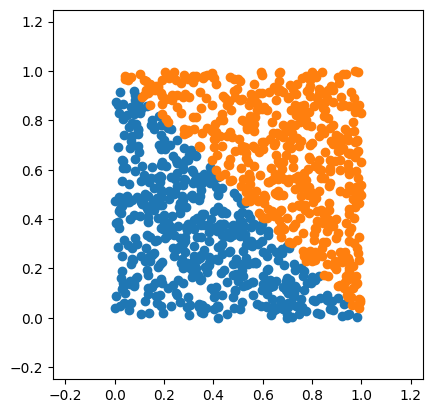

In [207]:
# Q2.6 - D2 scatter

data, labels = load_data('D2.txt')
tree = DecisionTree()
tree.fit(data, labels)

plot_decision_tree_regions(data, labels, tree, plot_boundary=False)

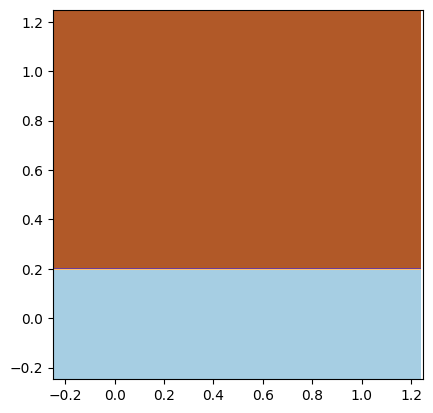

In [208]:
# Q2.6 - D1 decision boundary

data, labels = load_data('D1.txt')
tree = DecisionTree()
tree.fit(data, labels)

plot_decision_tree_regions(data, labels, tree, plot_scatter=False)

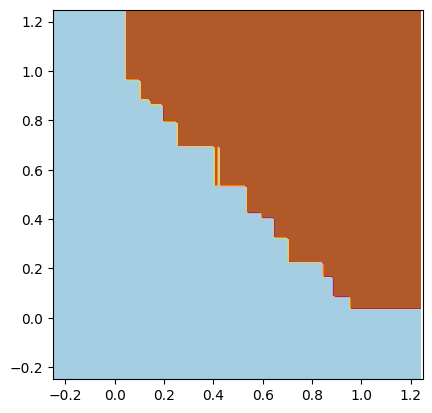

In [209]:
# Q2.6 - D2 decision boundary

data, labels = load_data('D2.txt')
tree = DecisionTree()
tree.fit(data, labels)

plot_decision_tree_regions(data, labels, tree, plot_scatter=False)

<ipython-input-240-90416be0b1dd>:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


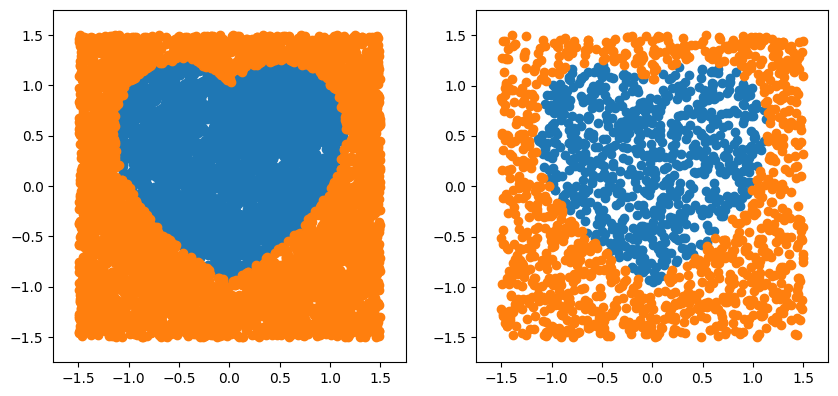

In [293]:
# Q2.7 - processing

data, labels = load_data('Dbig.txt')
(x_8192, y_8192), (x_test, y_test) = split_data(data, labels, 0.8192)
assert(x_8192.shape[0] == 8192 and y_8192.shape[0] == 8192)

# Visualizing Train and Test data
fig, axs = plt.subplots(1, 2, figsize=(10,5))
plot_decision_tree_regions(x_8192, y_8192, None, axs=axs[0], plot_boundary=False)
plot_decision_tree_regions(x_test, y_test, None, axs=axs[1], plot_boundary=False)

# Computing decision trees
training_set_sizes = [32, 128, 512, 2048, 8192]
lc_data = []
trees = []
for train_set_size in training_set_sizes:
    x = x_8192[:train_set_size]
    y = y_8192[:train_set_size]

    # Train model
    tree = DecisionTree()
    tree.fit(x, y)
    y_hat = tree.predict(x_test)
    error = np.mean(~np.equal(y_hat, y_test))

    # Store data for reporting
    lc_data.append((train_set_size, error))
    trees.append(tree)
lc_data = np.array(lc_data)

In [294]:
# Q2.7 - sub-question 1
pmatrix = [["Training set size (n)", "Number of nodes", "Error"]]
pmatrix += [[int(lc_data[i][0]), trees[i].root.node_count, lc_data[i][1]] for i in range(len(training_set_sizes))]
print(fmt_matrix(pmatrix, True))

| Training set size (n) | Number of nodes | Error                |
|———————————————————————|—————————————————|——————————————————————|
| 32                    | 9               | 0.10453539823008849  |
| 128                   | 13              | 0.0918141592920354   |
| 512                   | 57              | 0.05918141592920354  |
| 2048                  | 137             | 0.03650442477876106  |
| 8192                  | 265             | 0.018805309734513276 |


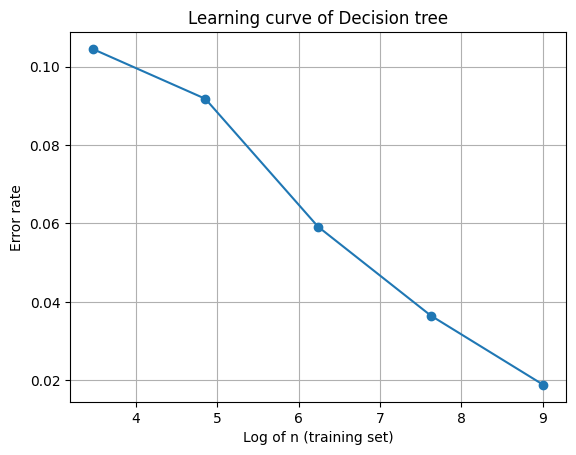

In [304]:
# Q2.7 - sub-question 2

x = np.log(lc_data[:,0])
y = lc_data[:,1]

# Create a plot
plt.plot(x, y, marker='o')

# Add labels and title
plt.xlabel('Log of n (training set)')
plt.ylabel('Error rate')
plt.title('Learning curve of Decision tree')

plt.grid(True)
plt.show()


Plotting Decision boundary for n=32


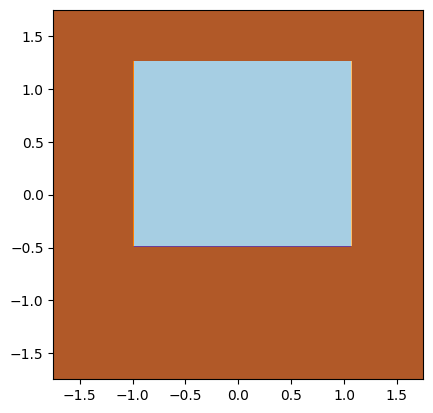

Plotting Decision boundary for n=128


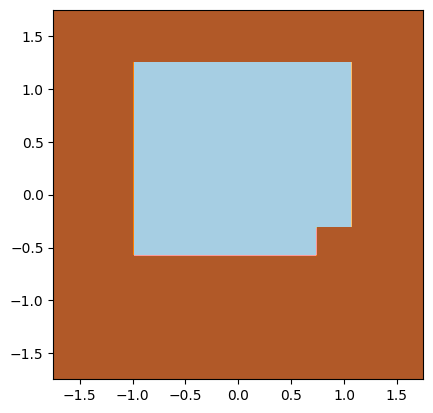

Plotting Decision boundary for n=512


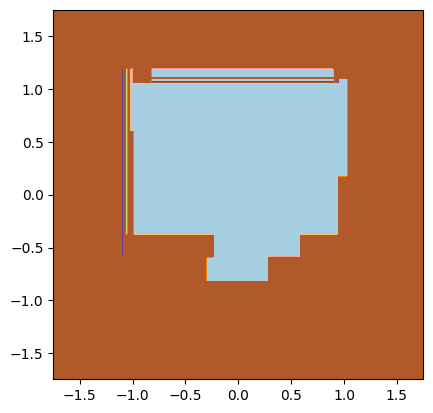

Plotting Decision boundary for n=2048


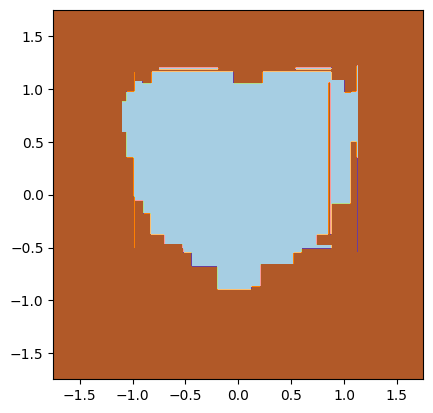

Plotting Decision boundary for n=8192


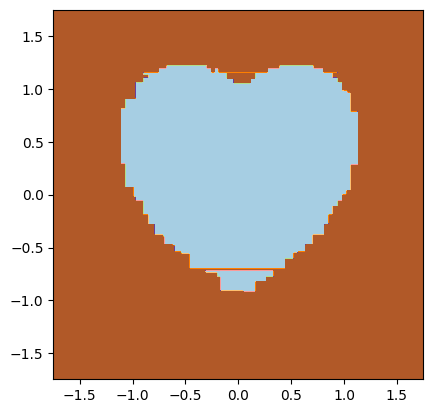

In [300]:
# Q2.7 - sub-question 3
n_plots = len(training_set_sizes)
for i in range(n_plots):
    print(f"Plotting Decision boundary for n={training_set_sizes[i]}")
    plot_decision_tree_regions(x_test, y_test, trees[i], plot_scatter=False)
    plt.show()
    print()

For sklearn DecisionTreeClassifier:
| Training set size (n) | Number of nodes | Error                |
|———————————————————————|—————————————————|——————————————————————|
| 32                    | 13              | 0.1277654867256637   |
| 128                   | 17              | 0.07743362831858407  |
| 512                   | 45              | 0.05530973451327434  |
| 2048                  | 121             | 0.025995575221238937 |
| 8192                  | 251             | 0.013827433628318585 |


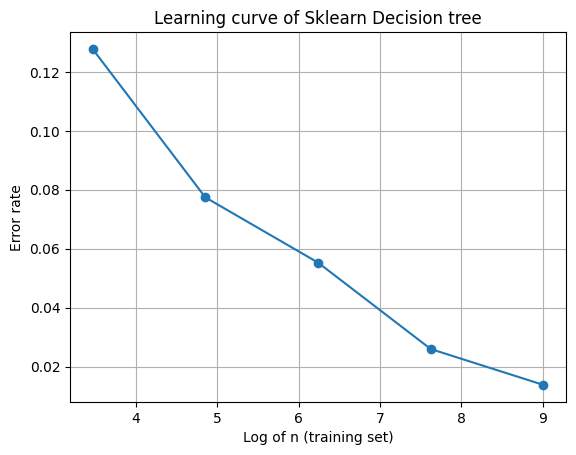

In [303]:
# Q3
from sklearn.tree import DecisionTreeClassifier

# Computing sklearn decision trees
sk_lc_data = []
sk_trees = []
for train_set_size in training_set_sizes:
    x = x_8192[:train_set_size]
    y = y_8192[:train_set_size]

    # Train model
    tree = DecisionTreeClassifier()
    tree.fit(x, y)
    y_hat = tree.predict(x_test)
    error = np.mean(~np.equal(y_hat, y_test))

    # Store data for reporting
    sk_lc_data.append((train_set_size, error))
    sk_trees.append(tree)
sk_lc_data = np.array(sk_lc_data)

# sub-question 1
sk_pmatrix = [["Training set size (n)", "Number of nodes", "Error"]]
sk_pmatrix += [[int(sk_lc_data[i][0]), sk_trees[i].tree_.node_count, sk_lc_data[i][1]] for i in range(len(training_set_sizes))]
print("For sklearn DecisionTreeClassifier:")
print(fmt_matrix(sk_pmatrix, True))

# sub-question 2
x = np.log(sk_lc_data[:,0])
y = sk_lc_data[:,1]

# Create a plot
plt.plot(x, y, marker='o')

# Add labels and title
plt.xlabel('Log of n (training set)')
plt.ylabel('Error rate')
plt.title('Learning curve of Sklearn Decision tree')

plt.grid(True)
plt.show()


Train error on pure training data: 341.9567363239069
Test error on pure training data: 342.1993182368803
Average test error on noisy training data: 347.170104131403



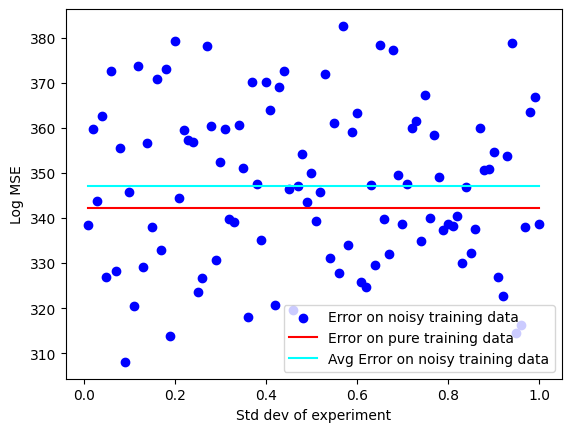

In [291]:
# Q4
from scipy.interpolate import lagrange
from sklearn.metrics import mean_squared_error

def generate_lagrange_exp_data(interval=[0, 2*np.pi], sample_size=100, noise_dev=None):
    x = np.random.uniform(*interval, size=sample_size)
    if noise_dev is not None:
        x += np.random.normal(scale=noise_dev, size=sample_size)
    return x

def compute_exp_error(x, y, lagrange_model):
    return np.log(mean_squared_error(y, lagrange_model(x)))

x_train_base = generate_lagrange_exp_data()
y_train_base = np.sin(x_train_base)
f_base = lagrange(x_train_base, y_train_base)

x_test_base = generate_lagrange_exp_data()
y_test_base = np.sin(x_test_base)

base_train_error = compute_exp_error(x_train_base, y_train_base, f_base)
base_test_error = compute_exp_error(x_test_base, y_test_base, f_base)
print("Train error on pure training data:", base_train_error)
print("Test error on pure training data:", base_test_error)

exp_results = []
for noise_dev in np.linspace(0.01,1,100):
    x_train_exp = generate_lagrange_exp_data()
    y_train_exp = np.sin(x_train_base)
    f_exp = lagrange(x_train_exp, y_train_exp)
    exp_error = compute_exp_error(x_test_base, y_test_base, f_exp)
    exp_results.append((noise_dev, exp_error))
exp_results = np.array(exp_results)

# Plot results
x_plot = exp_results[:,0] # Plotting x as per the linear iteration
y_exp_plot = exp_results[:,1]
exp_mean_test_error = np.mean(y_exp_plot)
y_base_plot = np.repeat(base_test_error, len(x_plot))
y_exp_mean_plot = np.repeat(exp_mean_test_error, len(x_plot))
print("Average test error on noisy training data:", exp_mean_test_error)
print()
plt.scatter(x_plot, y_exp_plot, label="Error on noisy training data", color="blue")
plt.plot(x_plot, y_base_plot, label="Error on pure training data", color="red")
plt.plot(x_plot, y_exp_mean_plot, label="Avg Error on noisy training data", color="cyan")
plt.xlabel("Std dev of experiment")
plt.ylabel("Log MSE")
plt.legend()
plt.show()